In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib_venn import venn2
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.compose import ColumnTransformer
import numpy as np
from catboost import CatBoostClassifier, Pool
import pickle

In [54]:
#загружаем трэйн
df_orders_flat = pd.read_parquet(r'data\fixed\df_orders_flat.parquet')

In [55]:
df_orders_flat_out = pd.read_parquet(r'data\fixed\df_orders_flat_out.parquet')

In [56]:
df_orders_flat

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,user_1,female,3,1.0,1.634292e+09,None,NaN,None,NaN
1,user_1,female,3,2.0,1.639827e+09,None,NaN,None,NaN
2,user_1,female,3,2.0,1.639828e+09,None,NaN,None,NaN
3,user_2,female,11,NaN,NaN,None,NaN,None,NaN
4,user_5,female,35,39.0,1.644809e+09,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...
2122025,user_127751,male,11,16.0,1.648560e+09,item_5409133,1.0,"[90590, 12327586, 90579, 198118]",1446.0
2122026,user_127751,male,11,16.0,1.649580e+09,item_56817,1.0,"[14333188, 10604398, 91009]",3503.0
2122027,user_127752,male,13,147.0,1.612968e+09,None,NaN,None,NaN
2122028,user_127752,male,13,147.0,1.612969e+09,None,NaN,None,NaN


In [57]:

#дропаем лишние столбцы (если они есть)
#columns_to_drop = ['median_length',  'average_common_categories', 'average_categories']
#df_orders_flat = df_orders_flat.drop(columns=columns_to_drop)

In [58]:
#загружаем валидацию
val = pd.read_parquet(r'data\fixed\val_test.parquet')

In [59]:
val_out = pd.read_parquet(r'data\fixed\val_test_out.parquet')

In [60]:
val

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,127757,0,16,16.0,1.636574e+09,item_3780263,2.0,"[90578, 90574, 198118]",1237.0
1,127757,0,16,16.0,1.637513e+09,item_5403882,2.0,"[90578, 90574, 198118]",1237.0
2,127757,0,16,16.0,1.637948e+09,item_1627033,1.0,"[91498, 91497, 91461, 198119]",1.0
3,127757,0,16,16.0,1.638631e+09,item_554781,1.0,"[90629, 90625, 10599873, 198119]",3519.0
4,127757,0,16,16.0,1.641841e+09,item_1898950,1.0,"[90578, 90574, 198118]",996.0
...,...,...,...,...,...,...,...,...,...
481824,155202,1,45,53.0,1.684604e+09,item_650360,1.0,None,NaN
481825,155202,1,45,53.0,1.684604e+09,item_650361,1.0,None,NaN
481826,155202,1,45,54.0,1.420435e+09,None,NaN,None,NaN
481827,155202,1,45,300.0,1.688068e+09,item_650362,1.0,"[818863, 15068776, 7811881, 7877999]",915491.0


In [61]:

def preprocess_dataframe(df):
    # Удаление выбранных столбцов
    #columns_to_drop = ['num_categories',	'num_common_categories',  'male_cat',	'female_cat']
    #columns_to_drop = ['created-at']
    #df = df.drop(columns=columns_to_drop)

    # Сбрасываем индексы, чтобы избежать дубликатов после explode
    df = df.reset_index(drop=True)
    #делаем explode для general-category-path   
    df = df.explode('general-category-path')
    
    
    df['id'] = df['id'].str.replace('item_', '')
    # Замена NaN на 0
    df = df.fillna(0)

    # Преобразование столбцов в int16
    int16_columns = ['site-id', 'count']
    df[int16_columns] = df[int16_columns].astype('int16')

    # Удаление слова 'user' в каждой строке столбца 'user_id'
    df['user_id'] = df['user_id'].str.replace('user_', '')

    # Преобразование столбца 'user_id' в int32
    df['user_id'] = df['user_id'].astype('int32')
    df['general-category-path'] = df['general-category-path'].astype('int32')
    
    df['brand-id'] = df['brand-id'].astype('int32')

       # Обработка столбца 'id'
    df['id'] = df['id'].astype('int32')
    

    # Преобразование 'target' в числовое представление
    df['target'] = df['target'].map({'male': 0, 'female': 1})

    return df




In [62]:

def preprocess_val_dataframe(df):
    # Удаление выбранных столбцов
    #columns_to_drop = ['num_categories',	'num_common_categories',  'male_cat',	'female_cat']
    #columns_to_drop = ['created-at']
    #df = df.drop(columns=columns_to_drop)

    # Сбрасываем индексы, чтобы избежать дубликатов после explode
    df = df.reset_index(drop=True)
    #делаем explode для general-category-path   
    df = df.explode('general-category-path')
    
    
    df['id'] = df['id'].str.replace('item_', '')
    # Замена NaN на 0
    df = df.fillna(0)

    # Преобразование столбцов в int16
    int16_columns = ['site-id', 'count']
    df[int16_columns] = df[int16_columns].astype('int16')

    # Удаление слова 'user' в каждой строке столбца 'user_id'
    #df['user_id'] = df['user_id'].str.replace('user_', '')

    # Преобразование столбца 'user_id' в int32
    df['user_id'] = df['user_id'].astype('int32')
    df['general-category-path'] = df['general-category-path'].astype('int32')
    
    df['brand-id'] = df['brand-id'].astype('int32')

       # Обработка столбца 'id'
    df['id'] = df['id'].astype('int32')
    

    # Преобразование 'target' в числовое представление
    #df['target'] = df['target'].map({'male': 0, 'female': 1})

    return df




In [63]:

df_orders_flat = preprocess_dataframe(df_orders_flat)

In [64]:
df_orders_flat_out = preprocess_dataframe(df_orders_flat_out)

In [65]:
val = preprocess_val_dataframe(val)

In [66]:
val_out = preprocess_val_dataframe(val_out)

In [67]:
val_out

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,127785,0,72,132,1.587289e+09,729610,0,0,0
1,127785,0,72,132,1.587289e+09,3841777,0,0,0
2,127785,0,72,2,1.535512e+09,424,1,0,0
3,127785,0,72,2,1.591619e+09,424,1,0,0
4,127785,0,72,2,1.625328e+09,8,1,0,0
...,...,...,...,...,...,...,...,...,...
333629,155172,1,127,317,1.606580e+09,4637117,3,5000962,34469
333629,155172,1,127,317,1.606580e+09,4637117,3,91615,34469
333629,155172,1,127,317,1.606580e+09,4637117,3,91609,34469
333629,155172,1,127,317,1.606580e+09,4637117,3,91597,34469


In [68]:

df_orders_flat_out

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,21,1,116,391,1.683183e+09,1642,34,0,0
1,21,1,116,391,1.683283e+09,1642,34,0,0
2,21,1,116,391,1.686145e+09,1643,40,0,0
3,21,1,116,391,1.686592e+09,1642,27,0,0
4,21,1,116,391,1.686592e+09,1644,2,0,0
...,...,...,...,...,...,...,...,...,...
1348609,127743,0,80,112,1.682406e+09,1660616,0,0,0
1348610,127743,0,80,112,1.682520e+09,3850967,0,0,0
1348611,127743,0,80,112,1.682520e+09,2811078,0,0,0
1348612,127743,0,80,112,1.682520e+09,1248095,0,0,0


In [69]:
val

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,127757,0,16,16,1.636574e+09,3780263,2,90578,1237
0,127757,0,16,16,1.636574e+09,3780263,2,90574,1237
0,127757,0,16,16,1.636574e+09,3780263,2,198118,1237
1,127757,0,16,16,1.637513e+09,5403882,2,90578,1237
1,127757,0,16,16,1.637513e+09,5403882,2,90574,1237
...,...,...,...,...,...,...,...,...,...
481827,155202,1,45,300,1.688068e+09,650362,1,818863,915491
481827,155202,1,45,300,1.688068e+09,650362,1,15068776,915491
481827,155202,1,45,300,1.688068e+09,650362,1,7811881,915491
481827,155202,1,45,300,1.688068e+09,650362,1,7877999,915491


In [70]:
# Разделение данных на train и test
X_train = df_orders_flat.drop(columns=['target'])
y_train = df_orders_flat['target']
X_test = val.drop(columns=['target'])
y_test = val['target']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Разделение данных на train и test
X_train_out = df_orders_flat_out.drop(columns=['target'])
y_train_out = df_orders_flat_out['target']
X_test_out = val_out.drop(columns=['target'])
y_test_out = val_out['target']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
X_test

,user_id,length,site-id,created-at,id,count,general-category-path,brand-id
0,127757,16,16,1.636574e+09,3780263,2,90578,1237
0,127757,16,16,1.636574e+09,3780263,2,90574,1237
0,127757,16,16,1.636574e+09,3780263,2,198118,1237
1,127757,16,16,1.637513e+09,5403882,2,90578,1237
1,127757,16,16,1.637513e+09,5403882,2,90574,1237
...,...,...,...,...,...,...,...,...
481827,155202,45,300,1.688068e+09,650362,1,818863,915491
481827,155202,45,300,1.688068e+09,650362,1,15068776,915491
481827,155202,45,300,1.688068e+09,650362,1,7811881,915491
481827,155202,45,300,1.688068e+09,650362,1,7877999,915491


C:\Users\Yury\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	test-error:0.25320	train-error:0.25860
[1]	test-error:0.25198	train-error:0.25859
[2]	test-error:0.25198	train-error:0.25859
[3]	test-error:0.25198	train-error:0.25859
[4]	test-error:0.25196	train-error:0.25882
[5]	test-error:0.24805	train-error:0.25319
[6]	test-error:0.24935	train-error:0.25695
[7]	test-error:0.24785	train-error:0.25396
[8]	test-error:0.24497	train-error:0.25037
[9]	test-error:0.24462	train-error:0.25143
[10]	test-error:0.24267	train-error:0.24896
[11]	test-error:0.24202	train-error:0.24803
[12]	test-error:0.24065	train-error:0.24632
[13]	test-error:0.24040	train-error:0.24596
[14]	test-error:0.24025	train-error:0.24554
[15]	test-error:0.23947	train-error:0.24468
[16]	test-error:0.23632	train-error:0.24194
[17]	test-error:0.23468	train-error:0.24123
[18]	test-error:0.23411	train-error:0.24047
[19]	test-error:0.23411	train-error:0.24027
[20]	test-error:0.23317	train-error:0.23960
[21]	test-error:0.23218	train-error:0.23871
[22]	test-error:0.23095	train-error:0.2372

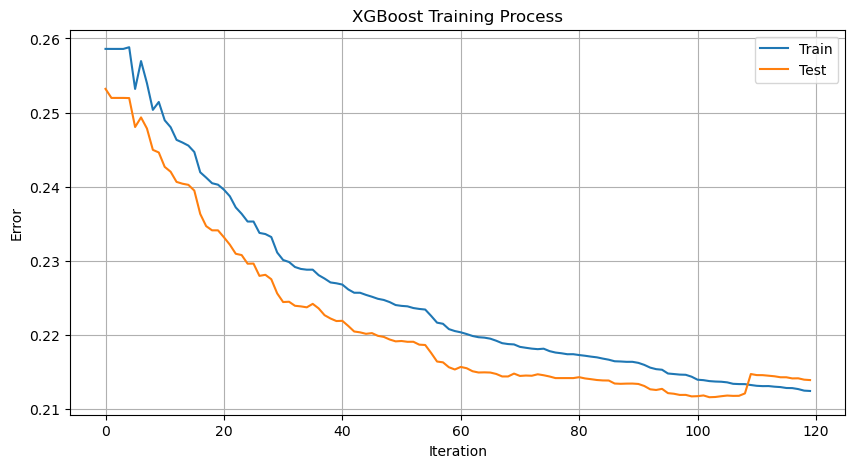

In [73]:

# Создание DMatrix для XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Определение параметров
param = {
    'max_depth': 3,  # глубина деревьев
    'eta': 0.3,  # шаг обучения
    'objective': 'binary:logistic',  # тип задачи
    'eval_metric': 'error'  # метрика оценки
}


# Обучение модели
num_round = 120 #эпохи
evals = [(dtest, 'test'), (dtrain, 'train')]
evals_result = {}
bst = xgb.train(param, dtrain, num_round, evals, early_stopping_rounds=10, evals_result=evals_result)

# Предсказание на тестовом наборе данных
preds = bst.predict(dtest)
predictions = [round(value) for value in preds]

# Вычисление точности
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

plt.figure(figsize=(10,5))
plt.plot(evals_result['train']['error'], label='Train')
plt.plot(evals_result['test']['error'], label='Test')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('XGBoost Training Process')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
X_test

,user_id,length,site-id,created-at,id,count,general-category-path,brand-id
0,127757,16,16,1.636574e+09,3780263,2,90578,1237
0,127757,16,16,1.636574e+09,3780263,2,90574,1237
0,127757,16,16,1.636574e+09,3780263,2,198118,1237
1,127757,16,16,1.637513e+09,5403882,2,90578,1237
1,127757,16,16,1.637513e+09,5403882,2,90574,1237
...,...,...,...,...,...,...,...,...
481827,155202,45,300,1.688068e+09,650362,1,818863,915491
481827,155202,45,300,1.688068e+09,650362,1,15068776,915491
481827,155202,45,300,1.688068e+09,650362,1,7811881,915491
481827,155202,45,300,1.688068e+09,650362,1,7877999,915491


In [75]:
X_test_out

,user_id,length,site-id,created-at,id,count,general-category-path,brand-id
0,127785,72,132,1.587289e+09,729610,0,0,0
1,127785,72,132,1.587289e+09,3841777,0,0,0
2,127785,72,2,1.535512e+09,424,1,0,0
3,127785,72,2,1.591619e+09,424,1,0,0
4,127785,72,2,1.625328e+09,8,1,0,0
...,...,...,...,...,...,...,...,...
333629,155172,127,317,1.606580e+09,4637117,3,5000962,34469
333629,155172,127,317,1.606580e+09,4637117,3,91615,34469
333629,155172,127,317,1.606580e+09,4637117,3,91609,34469
333629,155172,127,317,1.606580e+09,4637117,3,91597,34469


In [76]:

#обучим датасеты без выбросов

# Создание пула данных для CatBoost
train_pool = Pool(X_train, y_train, group_id=X_train['user_id'],  cat_features=['brand-id', 'site-id', 'general-category-path', 'id'] )
test_pool = Pool(X_test, y_test, group_id=X_test['user_id'],  cat_features=['brand-id', 'site-id', 'general-category-path', 'id'])
#group_id=X_train['user_id'],  cat_features=['brand-id', 'site-id', 'general-category-path', 'id']
#group_id=X_test['user_id'], cat_features=['brand-id', 'site-id', 'general-category-path', 'id']
# Определение параметров
params = {
    'iterations': 150,
    'depth': 3,
    'learning_rate':0.45,
    'l2_leaf_reg': 5,
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'verbose': 10,
    
    'random_state': 42
}

# Создание и обучение модели
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7784846	test: 0.7824991	best: 0.7824991 (0)	total: 892ms	remaining: 2m 12s
10:	learn: 0.8618692	test: 0.7887292	best: 0.7887292 (10)	total: 4.9s	remaining: 1m 1s
20:	learn: 0.8635586	test: 0.7908182	best: 0.7908182 (20)	total: 8.1s	remaining: 49.8s
30:	learn: 0.8640899	test: 0.7912166	best: 0.7913601 (29)	total: 11.3s	remaining: 43.3s
40:	learn: 0.8643399	test: 0.7923748	best: 0.7923748 (40)	total: 14.6s	remaining: 38.8s
50:	learn: 0.8658088	test: 0.7930271	best: 0.7930847 (46)	total: 17.9s	remaining: 34.7s
60:	learn: 0.8671576	test: 0.7926807	best: 0.7930847 (46)	total: 21.1s	remaining: 30.8s
70:	learn: 0.8682140	test: 0.7924560	best: 0.7930847 (46)	total: 24.3s	remaining: 27s
80:	learn: 0.8689600	test: 0.7923465	best: 0.7930847 (46)	total: 27.6s	remaining: 23.5s
90:	learn: 0.8697362	test: 0.7925013	best: 0.7930847 (46)	total: 30.7s	remaining: 19.9s
100:	learn: 0.8700231	test: 0.7929356	best: 0.7930847 (46)	total: 34s	remaining: 16.5s
110:	learn: 0.8702775	test: 0.7920209	

In [77]:
#обучим датасеты с выбросами
# Создание пула данных для CatBoost
train_pool_out = Pool(X_train_out, y_train_out, group_id=X_train_out['user_id'],  cat_features=['brand-id', 'site-id', 'general-category-path', 'id'])

test_pool_out = Pool(X_test_out,  y_test_out, group_id=X_test_out['user_id'], cat_features=['brand-id', 'site-id', 'general-category-path', 'id'] )
#group_id=X_train['user_id'],  cat_features=['brand-id', 'site-id', 'general-category-path', 'id']
#group_id=X_test['user_id'], cat_features=['brand-id', 'site-id', 'general-category-path', 'id']
# Определение параметров
params_out = {
    'iterations': 40,
    'depth': 3,
    'learning_rate':0.45,
    'l2_leaf_reg': 5,
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'verbose': 10,
    
    'random_state': 42
}

# Создание и обучение модели
model_out = CatBoostClassifier(**params_out)
model_out.fit(train_pool_out, eval_set=test_pool_out, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7600535	test: 0.7601644	best: 0.7601644 (0)	total: 447ms	remaining: 17.4s
10:	learn: 0.8644684	test: 0.7504238	best: 0.7601644 (0)	total: 2.99s	remaining: 7.89s
20:	learn: 0.8681417	test: 0.7509323	best: 0.7601644 (0)	total: 5.08s	remaining: 4.6s
30:	learn: 0.8715247	test: 0.7520839	best: 0.7601644 (0)	total: 7.12s	remaining: 2.07s
39:	learn: 0.8728269	test: 0.7523207	best: 0.7601644 (0)	total: 8.95s	remaining: 0us

bestTest = 0.7601644321
bestIteration = 0

Shrink model to first 1 iterations.


In [78]:
predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, predictions)
predictions = pd.Series(predictions, name='predictions')
print(f'Accuracy Model : {accuracy1}')


Accuracy Model : 0.7930846991724256


In [79]:
result = pd.concat([X_test.reset_index(drop=True), predictions], axis=1, ignore_index=True)

result

,0,1,2,3,4,5,6,7,8
0,127757,16,16,1.636574e+09,3780263,2,90578,1237,0
1,127757,16,16,1.636574e+09,3780263,2,90574,1237,0
2,127757,16,16,1.636574e+09,3780263,2,198118,1237,0
3,127757,16,16,1.637513e+09,5403882,2,90578,1237,0
4,127757,16,16,1.637513e+09,5403882,2,90574,1237,0
...,...,...,...,...,...,...,...,...,...
1059356,155202,45,300,1.688068e+09,650362,1,818863,915491,1
1059357,155202,45,300,1.688068e+09,650362,1,15068776,915491,1
1059358,155202,45,300,1.688068e+09,650362,1,7811881,915491,1
1059359,155202,45,300,1.688068e+09,650362,1,7877999,915491,1


In [80]:
# Переименовать столбцы
result.columns = ['user_id', 'length', 'site-id', 'created-at', 'id', 'count', 'general-category-path', 'brand-id', 'predictions']

# Удалить лишние столбцы
result.drop(columns=['length', 'site-id', 'created-at', 'id', 'count', 'general-category-path', 'brand-id'], inplace=True)



In [81]:

# Сгруппировать по user_id

grouped_df = result.groupby('user_id')['predictions'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='prediction')
#grouped_df = result.groupby('user_id')['predictions'].mode().reset_index()

# Округлить результат
#grouped_df['predictions'] = grouped_df['predictions']).astype(int)
grouped_df

,user_id,prediction
0,127756,1
1,127757,0
2,127758,1
3,127759,1
4,127760,0
...,...,...
25623,155198,1
25624,155199,0
25625,155200,1
25626,155201,1


In [82]:
predictions_out = model_out.predict(X_test_out)
accuracy2 = accuracy_score(y_test_out, predictions_out)
predictions_out = pd.Series(predictions_out, name='predictions')
print(f'Accuracy Model : {accuracy2}')

Accuracy Model : 0.7601644320572639


In [83]:
result_out = pd.concat([X_test_out.reset_index(drop=True), predictions_out], axis=1, ignore_index=True)
# Переименовать столбцы
result_out.columns = ['user_id', 'length', 'site-id', 'created-at', 'id', 'count', 'general-category-path', 'brand-id', 'predictions']

# Удалить лишние столбцы
result_out.drop(columns=['length', 'site-id', 'created-at', 'id', 'count', 'general-category-path', 'brand-id'], inplace=True)


In [84]:

grouped_out_df = result_out.groupby('user_id')['predictions'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='prediction')
#grouped_out_df = result_out.groupby('user_id')['predictions'].mean().reset_index()

# Округлить результат
#grouped_out_df['predictions'] = np.round(grouped_out_df['predictions']).astype(int)
grouped_out_df

,user_id,prediction
0,127785,0
1,127787,1
2,127788,0
3,127802,1
4,127804,1
...,...,...
1814,155129,0
1815,155136,1
1816,155142,1
1817,155153,1


In [85]:
result_union = pd.concat([grouped_df, grouped_out_df], ignore_index=True)
result_union

,user_id,prediction
0,127756,1
1,127757,0
2,127758,1
3,127759,1
4,127760,0
...,...,...
27442,155129,0
27443,155136,1
27444,155142,1
27445,155153,1


In [87]:
#загружаем итоговую валидацию

val_final = pd.read_parquet(r'data\fixed\val_final.parquet')

In [88]:
final_df = pd.merge(result_union, val_final, how='left', on='user_id')
final_df

,user_id,prediction,target
0,127756,1,1
1,127757,0,0
2,127758,1,1
3,127759,1,1
4,127760,0,1
...,...,...,...
27442,155129,0,0
27443,155136,1,1
27444,155142,1,1
27445,155153,1,1


In [89]:
# Рассчитать accuracy
accuracy = accuracy_score(final_df['target'], final_df['prediction'])

print(f'Accuracy: {accuracy}')

Accuracy: 0.7062338324771378


In [90]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,id,49.453305
1,length,33.295237
2,site-id,11.324744
3,general-category-path,3.574200
4,brand-id,1.858236
5,created-at,0.408498
6,user_id,0.069631
7,count,0.016149


In [91]:
#загружаем test
test = pd.read_parquet(r'data\fixed\test_test.parquet')

In [92]:
test = preprocess_val_dataframe(test)
test

,user_id,length,site-id,created-at,id,count,general-category-path,brand-id
0,155203,17,0,0.000000e+00,0,0,0,0
1,155204,27,489,1.405923e+09,0,0,0,0
2,155205,3,0,0.000000e+00,0,0,0,0
3,155206,33,62,1.621174e+09,13288,1,91214,0
3,155206,33,62,1.621174e+09,13288,1,91197,0
...,...,...,...,...,...,...,...,...
535403,173986,189,79,1.563164e+09,6640460,1,7812151,1750
535403,173986,189,79,1.563164e+09,6640460,1,7811877,1750
535403,173986,189,79,1.563164e+09,6640460,1,7877999,1750
535404,173986,189,79,1.628942e+09,0,0,0,0


In [94]:
predictions = model.predict(test)
predictions = pd.Series(predictions, name='predictions')
predictions

0          0
1          0
2          0
3          0
4          0
          ..
1212673    1
1212674    1
1212675    1
1212676    1
1212677    1
Name: predictions, Length: 1212678, dtype: int64

In [103]:
result = test['user_id'].reset_index()
result

,index,user_id
0,0,155203
1,1,155204
2,2,155205
3,3,155206
4,3,155206
...,...,...
1212673,535403,173986
1212674,535403,173986
1212675,535403,173986
1212676,535404,173986


In [104]:
result = pd.concat([result, predictions], axis=1, ignore_index=True)
result.columns = ['index', 'user_id', 'predictions']
result.drop(columns=['index'], inplace=True)

result

,user_id,predictions
0,155203,0
1,155204,0
2,155205,0
3,155206,0
4,155206,0
...,...,...
1212673,173986,1
1212674,173986,1
1212675,173986,1
1212676,173986,1


In [ ]:
# Сгруппировать по user_id
grouped_df = result.groupby('user_id')['predictions'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='prediction')
grouped_df